In [1]:
import os.path as osp

import torch
from tqdm import tqdm
import numpy as np

from torch_geometric.nn import LightGCN
from torch_geometric.utils import degree

In [2]:
import os
import os.path as osp
from typing import Callable, Optional

import pandas as pd
from torch_geometric.data import HeteroData, InMemoryDataset, download_url, extract_zip

class MovieLens100K(InMemoryDataset):
    url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'

    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        force_reload: bool = False,
    ):
        super().__init__(root, transform, pre_transform, force_reload=force_reload)
        self.load(self.processed_paths[0], data_cls=HeteroData)

    @property
    def raw_file_names(self) -> list:
        return ['u.item', 'u.user', 'u1.base', 'u1.test']

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self) -> None:
        path = download_url(self.url, self.root)
        extract_zip(path, self.root)
        os.remove(path)
        folder = osp.join(self.root, 'ml-100k')
        os.rename(folder, self.raw_dir)

    def process(self) -> None:
        data = HeteroData()

        # Process users:
        user_df = pd.read_csv(
            osp.join(self.raw_dir, 'u.user'),
            sep='|',
            header=None,
            names=['userId', 'age', 'gender', 'occupation', 'zipCode'],
            encoding='ISO-8859-1',
        )
        data['user'].num_nodes = len(user_df)

        # Process movies:
        movie_df = pd.read_csv(
            osp.join(self.raw_dir, 'u.item'),
            sep='|',
            header=None,
            names=[
                "movieId", "title", "releaseDate", "videoReleaseDate", "IMDb URL",
                "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy",
                "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
                "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
            ],
            encoding='ISO-8859-1',
            usecols=['movieId'],
        )
        data['movie'].num_nodes = len(movie_df)

        # Process edges for training and testing:
        edge_attrs = ['edge_index', 'edge_label_index']
        for edge_attr, raw_path in zip(edge_attrs, ['u1.base', 'u1.test']):
            edges_df = pd.read_csv(
                osp.join(self.raw_dir, raw_path),
                sep='\t',
                header=None,
                names=['userId', 'movieId', 'rating', 'timestamp'],
            )
            src = edges_df['userId'].values - 1  # Adjusting index to start from 0
            dst = edges_df['movieId'].values - 1  # Adjusting index to start from 0
            index = torch.tensor(np.array([src, dst]))
            data['user', 'rates', 'movie'][edge_attr] = index
            if edge_attr == 'edge_index':
                data['movie', 'rated_by', 'user'][edge_attr] = index.flip([0])

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        self.save([data], self.processed_paths[0])


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path = osp.join(osp.dirname(osp.realpath('projectFINAL.ipynb')), '', 'data', 'MovieLens')
dataset = MovieLens100K(path)
data = dataset[0]
num_users, num_movies = data['user'].num_nodes, data['movie'].num_nodes
data = data.to_homogeneous().to(device)

In [4]:
from torch import Tensor
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import is_sparse, to_edge_index
from typing import List

class ResidualLightGCN(LightGCN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_embeddings_per_layer(
        self,
        edge_index: Adj,
        edge_weight: OptTensor = None,
    ) -> List[Tensor]:
        """Returns the embeddings of nodes in the graph for each layer."""
        x = self.embedding.weight
        embeddings = [x]

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index, edge_weight)
            embeddings.append(x)

        return embeddings

    def forward(
        self,
        edge_index: Adj,
        edge_label_index: OptTensor = None,
        edge_weight: OptTensor = None,
    ) -> Tensor:
        r"""Computes rankings for pairs of nodes.

        Args:
            edge_index (torch.Tensor or SparseTensor): Edge tensor specifying
                the connectivity of the graph.
            edge_label_index (torch.Tensor, optional): Edge tensor specifying
                the node pairs for which to compute rankings or probabilities.
                If :obj:`edge_label_index` is set to :obj:`None`, all edges in
                :obj:`edge_index` will be used instead. (default: :obj:`None`)
            edge_weight (torch.Tensor, optional): The weight of each edge in
                :obj:`edge_index`. (default: :obj:`None`)
        """
        if edge_label_index is None:
            if is_sparse(edge_index):
                edge_label_index, _ = to_edge_index(edge_index)
            else:
                edge_label_index = edge_index

        embeddings = self.get_embeddings_per_layer(edge_index, edge_weight)

        pred = torch.zeros(edge_label_index.size(1), device=edge_index.device)
        for i, alpha in enumerate(self.alpha):
            out_src = embeddings[i][edge_label_index[0]]
            out_dst = embeddings[i][edge_label_index[1]]
            pred += alpha * (out_src * out_dst).sum(dim=-1)

        return pred
    
    def recommend(
        self,
        edge_index: Adj,
        edge_weight: OptTensor = None,
        src_index: OptTensor = None,
        dst_index: OptTensor = None,
        k: int = 1,
        sorted: bool = True,
    ) -> Tensor:
        r"""Get top-:math:`k` recommendations for nodes in :obj:`src_index`.

        Args:
            edge_index (torch.Tensor or SparseTensor): Edge tensor specifying
                the connectivity of the graph.
            edge_weight (torch.Tensor, optional): The weight of each edge in
                :obj:`edge_index`. (default: :obj:`None`)
            src_index (torch.Tensor, optional): Node indices for which
                recommendations should be generated.
                If set to :obj:`None`, all nodes will be used.
                (default: :obj:`None`)
            dst_index (torch.Tensor, optional): Node indices which represent
                the possible recommendation choices.
                If set to :obj:`None`, all nodes will be used.
                (default: :obj:`None`)
            k (int, optional): Number of recommendations. (default: :obj:`1`)
            sorted (bool, optional): Whether to sort the recommendations
                by score. (default: :obj:`True`)
        """
        embeddings = self.get_embeddings_per_layer(edge_index, edge_weight)

        out_src = out_dst = sum(alpha * emb for alpha, emb in zip(self.alpha, embeddings))

        if src_index is not None:
            out_src = out_src[src_index]

        if dst_index is not None:
            out_dst = out_dst[dst_index]

        pred = out_src @ out_dst.t()
        top_index = pred.topk(k, dim=-1, sorted=sorted).indices

        if dst_index is not None:
            top_index = dst_index[top_index.view(-1)].view(*top_index.size())

        return top_index


In [5]:
# Use all message passing edges as training labels:
batch_size = 512
mask = data.edge_index[0] < data.edge_index[1]
train_edge_label_index = data.edge_index[:, mask]
train_loader = torch.utils.data.DataLoader(
    range(train_edge_label_index.size(1)),
    shuffle=True,
    batch_size=batch_size,
)

embedding_dim=64
num_layers=2
lr = 0.001

RLightGCN = ResidualLightGCN(
    num_nodes=data.num_nodes,
    embedding_dim=embedding_dim,
    num_layers=num_layers,
).to(device)
optimizer = torch.optim.Adam(RLightGCN.parameters(), lr=lr)

In [6]:
def train(model: torch.nn.Module):
    model.train()
    total_loss = total_examples = 0

    for index in tqdm(train_loader):
        pos_edge_label_index = train_edge_label_index[:, index]
        neg_edge_label_index = torch.stack([
            pos_edge_label_index[0],
            torch.randint(num_users, num_users + num_movies,
                          (index.numel(), ), device=device)
        ], dim=0)
        edge_label_index = torch.cat([
            pos_edge_label_index,
            neg_edge_label_index,
        ], dim=1)

        optimizer.zero_grad()
        pos_rank, neg_rank = model(data.edge_index, edge_label_index).chunk(2)

        loss = model.recommendation_loss(
            pos_rank,
            neg_rank,
            node_id=edge_label_index.unique(),
        )
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * pos_rank.numel()
        total_examples += pos_rank.numel()

    return total_loss / total_examples

@torch.no_grad()
def test(model: torch.nn.Module, k: int):
    model.eval()
    embeddings_per_layer = model.get_embeddings_per_layer(data.edge_index)
    num_layers = len(embeddings_per_layer)

    emb = sum(model.alpha[i] * embeddings_per_layer[i] for i in range(num_layers))
    user_emb, movie_emb = emb[:num_users], emb[num_users:]

    precision = recall = total_examples = 0
    for start in range(0, num_users, batch_size):
        end = start + batch_size
        logits = user_emb[start:end] @ movie_emb.t()

        mask = ((train_edge_label_index[0] >= start) &
                (train_edge_label_index[0] < end))
        logits[train_edge_label_index[0, mask] - start,
               train_edge_label_index[1, mask] - num_users] = float('-inf')

        ground_truth = torch.zeros_like(logits, dtype=torch.bool)
        mask = ((data.edge_label_index[0] >= start) & (data.edge_label_index[0] < end))
        ground_truth[data.edge_label_index[0, mask] - start,
                     data.edge_label_index[1, mask] - num_users] = True
        node_count = degree(data.edge_label_index[0, mask] - start,
                            num_nodes=logits.size(0))

        topk_index = logits.topk(k, dim=-1).indices
        isin_mat = ground_truth.gather(1, topk_index)

        precision += float((isin_mat.sum(dim=-1) / k).sum())
        recall += float((isin_mat.sum(dim=-1) / node_count.clamp(1e-6)).sum())
        total_examples += int((node_count > 0).sum())

    return precision / total_examples, recall / total_examples


In [7]:
losses = []
precisions = []
recalls = []

n_epochs = 2
k = 20

for epoch in range(1, n_epochs + 1):
    loss = train(model=RLightGCN)
    precision, recall = test(model=RLightGCN, k=k)
    print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Precision@{k}: '
          f'{precision:.4f}, Recall@{k}: {recall:.4f}')
    losses.append(loss)
    precisions.append(precision)
    recalls.append(recall)
    
torch.save(RLightGCN.state_dict(), 'ResidualLightGCN.pth')

  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:10<00:00, 15.51it/s]


Epoch: 001, Train Loss: 0.6764, Precision@20: 0.2636, Recall@20: 0.1592


100%|██████████| 157/157 [00:08<00:00, 19.14it/s]

Epoch: 002, Train Loss: 0.4783, Precision@20: 0.2697, Recall@20: 0.1712


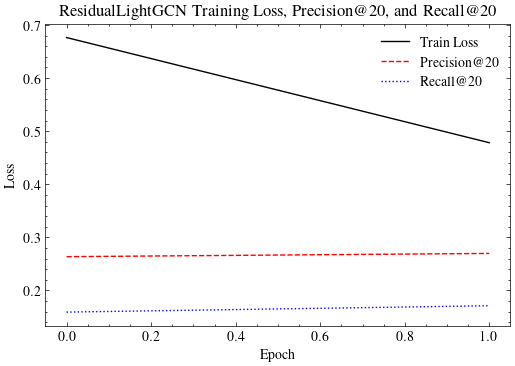

In [8]:
import matplotlib.pyplot as plt
import scienceplots

dpi=100

plt.style.use(['science', 'ieee'])
plt.figure(dpi=dpi)
plt.plot(losses, label='Train Loss')
plt.plot(precisions, label=f'Precision@{k}')
plt.plot(recalls, label=f'Recall@{k}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'ResidualLightGCN Training Loss, Precision@{k}, and Recall@{k}')
plt.legend()
#plt.savefig('../Results/residuallightgcn.png', dpi=300, bbox_inches='tight')
plt.show()


### Train and evaluate regular LightGCN model for comparison

In [9]:
LightGCN = LightGCN(
    num_nodes=data.num_nodes,
    embedding_dim=embedding_dim,
    num_layers=num_layers,
).to(device)
optimizer = torch.optim.Adam(LightGCN.parameters(), lr=lr)

In [10]:
def train_LightGCN(model: torch.nn.Module):
    model.train()
    total_loss = total_examples = 0

    for index in tqdm(train_loader):
        pos_edge_label_index = train_edge_label_index[:, index]
        neg_edge_label_index = torch.stack([
            pos_edge_label_index[0],
            torch.randint(num_users, num_users + num_movies,
                          (index.numel(), ), device=device)
        ], dim=0)
        edge_label_index = torch.cat([
            pos_edge_label_index,
            neg_edge_label_index,
        ], dim=1)

        optimizer.zero_grad()
        pos_rank, neg_rank = model(data.edge_index, edge_label_index).chunk(2)

        loss = model.recommendation_loss(
            pos_rank,
            neg_rank,
            node_id=edge_label_index.unique(),
        )
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * pos_rank.numel()
        total_examples += pos_rank.numel()

    return total_loss / total_examples

@torch.no_grad()
def test_LightGCN(model: torch.nn.Module, k: int):
    model.eval()
    emb = model.get_embedding(data.edge_index)
    user_emb, movie_emb = emb[:num_users], emb[num_users:]

    precision = recall = total_examples = total_loss = 0
    for start in range(0, num_users, batch_size):
        end = start + batch_size
        logits = user_emb[start:end] @ movie_emb.t()

        mask = ((train_edge_label_index[0] >= start) &
                (train_edge_label_index[0] < end))
        logits[train_edge_label_index[0, mask] - start,
               train_edge_label_index[1, mask] - num_users] = float('-inf')

        ground_truth = torch.zeros_like(logits, dtype=torch.bool)
        mask = ((data.edge_label_index[0] >= start) & (data.edge_label_index[0] < end))
        ground_truth[data.edge_label_index[0, mask] - start,
                     data.edge_label_index[1, mask] - num_users] = True
        node_count = degree(data.edge_label_index[0, mask] - start,
                            num_nodes=logits.size(0))

        topk_index = logits.topk(k, dim=-1).indices
        isin_mat = ground_truth.gather(1, topk_index)

        precision += float((isin_mat.sum(dim=-1) / k).sum())
        recall += float((isin_mat.sum(dim=-1) / node_count.clamp(1e-6)).sum())
        total_examples += int((node_count > 0).sum())

    return precision / total_examples, recall / total_examples


In [11]:
losses_LightGCN = []
precisions_LightGCN = []
recalls_LightGCN = []

for epoch in range(1, n_epochs + 1):
    loss = train_LightGCN(model=LightGCN)
    precision, recall = test_LightGCN(model=LightGCN, k=k)
    print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Precision@{k}: '
          f'{precision:.4f}, Recall@{k}: {recall:.4f}, ')
    losses_LightGCN.append(loss)
    precisions_LightGCN.append(precision)
    recalls_LightGCN.append(recall)

torch.save(LightGCN.state_dict(), 'LightGCN.pth')


100%|██████████| 157/157 [00:08<00:00, 18.23it/s]


Epoch: 001, Train Loss: 0.6186, Precision@20: 0.2603, Recall@20: 0.1592, 


100%|██████████| 157/157 [00:08<00:00, 19.15it/s]

Epoch: 002, Train Loss: 0.4261, Precision@20: 0.2703, Recall@20: 0.1712, 


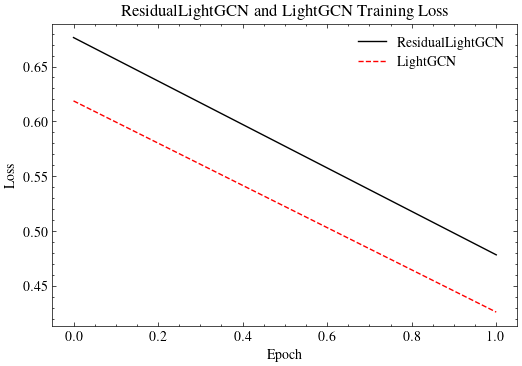

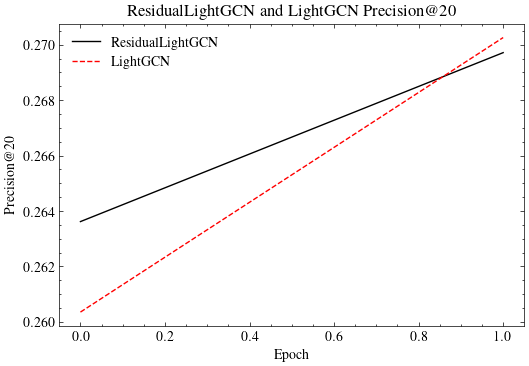

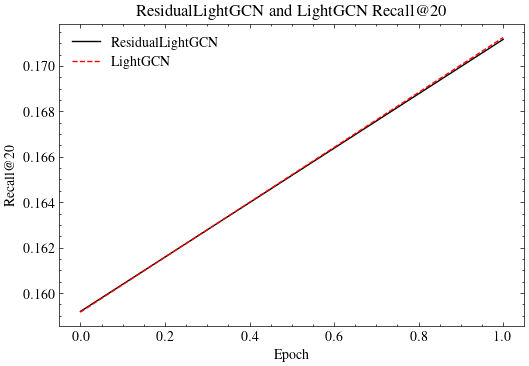

In [12]:
import matplotlib.pyplot as plt


plt.figure(dpi=dpi)
plt.plot(losses, label='ResidualLightGCN')
plt.plot(losses_LightGCN, label='LightGCN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResidualLightGCN and LightGCN Training Loss')
plt.legend()
#plt.savefig('../Results/loss_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(dpi=dpi)
plt.plot(precisions, label='ResidualLightGCN')
plt.plot(precisions_LightGCN, label='LightGCN')
plt.xlabel('Epoch')
plt.ylabel(f'Precision@{k}')
plt.title(f'ResidualLightGCN and LightGCN Precision@{k}')
plt.legend()
#plt.savefig('../Results/precision_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(dpi=dpi)
plt.plot(recalls, label='ResidualLightGCN')
plt.plot(recalls_LightGCN, label='LightGCN')
plt.xlabel('Epoch')
plt.ylabel(f'Recall@{k}')
plt.title(f'ResidualLightGCN and LightGCN Recall@{k}')
plt.legend()
#plt.savefig('../Results/recall_comparison.png', dpi=300, bbox_inches='tight')
plt.show()